In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
#import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from itertools import cycle
import random
from collections import Counter
from tqdm import tqdm
from vips import vipp

In [2]:

## ALREADY PREPROCESSED 
#### Min gene count = 0 for 15% of samples

train_fpkm = pd.read_csv("../data/BAL/train_fpkm_minfilter0_log2.csv",sep='\t',index_col=0)
train_meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

test_fpkm = pd.read_csv("../data/BAL/test_fpkm_minfilter0_log2.csv", sep='\t', index_col=0)
test_meta = pd.read_csv('../data/BAL/meta_r0.csv', sep='\t', index_col=0)


In [3]:
print test_fpkm.shape, test_meta.shape
print train_fpkm.shape, train_meta.shape

(32, 26081) (32, 2)
(95, 11957) (95, 32)


In [4]:
train_meta['sum_fpkm'] = train_fpkm.apply(lambda x: np.sum(x), axis=1)
test_meta['sum_fpkm'] = test_fpkm.apply(lambda x: np.sum(x), axis=1)

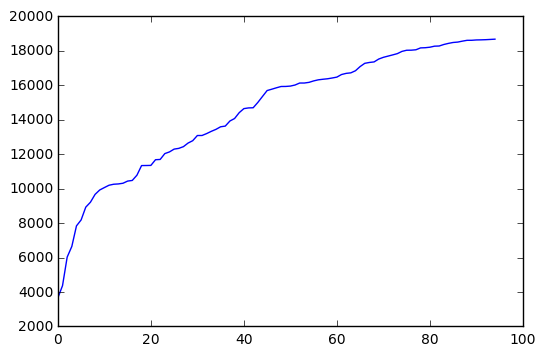

In [5]:
plt.plot(sorted(train_meta['sum_fpkm']))

### Optional filtering by total fpkm count

In [6]:
#test_meta = test_meta[test_meta['sum_fpkm'] > 15000]
#train_meta = train_meta[train_meta['sum_fpkm'] > 10000]

#test_fpkm =  test_fpkm.ix[test_meta.index]
#train_fpkm = train_fpkm.ix[train_meta.index]

In [6]:
test_meta.shape, train_meta.shape

((32, 3), (95, 33))

### exclude BAL 18,19

In [7]:
to_remove = ['BAL18','BAL19']
new_index = [i for i in train_fpkm.index if not any(rem in i for rem in to_remove)]
train_fpkm = train_fpkm.ix[new_index]
train_meta = train_meta.ix[new_index]

In [8]:
train_meta['Pneum'].value_counts()

False    60
True     34
Name: Pneum, dtype: int64

## Reclassify, Based on Mac's email 9/14/17

In [9]:
old_pos = train_meta[train_meta['Pneum']==True]
old_pos_bals = old_pos['BAL'].values
old_pos_bals

array(['BAL28', 'BAL38', 'BAL48', 'BAL53', 'BAL55', 'BAL64', 'BAL75',
       'BAL75', 'BAL79', 'BAL87', 'BAL87', 'BAL28', 'BAL33', 'BAL33',
       'BAL38', 'BAL45', 'BAL46', 'BAL46', 'BAL49', 'BAL50', 'BAL51',
       'BAL51', 'BAL53', 'BAL55', 'BAL57', 'BAL60', 'BAL60', 'BAL67',
       'BAL67', 'BAL79', 'BAL83', 'BAL83', 'BAL86', 'BAL86'], dtype=object)

In [10]:
## Based on Mac's email 9/14/17
f = open('../data/BAL/final_positives.txt','r').readlines()
new_pos_bals = np.array([str('BAL' + i).rstrip() for i in f if len(i)>1])

In [11]:
new_pos_bals.shape

(29,)

In [12]:
train_meta['Pneum'] = train_meta['BAL'].map(lambda x: x in new_pos_bals)
train_meta['Pneum'].value_counts()

False    60
True     34
Name: Pneum, dtype: int64

In [13]:
train_meta.shape

(94, 33)

## Functions for ML algorithms, AUROC

In [14]:
### Used to get X y data from original counts dataframe. 
### We decided to use sampling=None as up/down-sampling are not easy to intrepret.

def geteven_xy(df, dfm, celltype, sampling=None, norm='zscore'):
    
    '''
    df -> counts
    dfm -> meta data
    celltype -> 'AM' or 'CD163'
    sampling -> 'up', 'down', or None
    normalization -> zscore, 'zero_one' (scales data from 0 to 1), or None
    
    '''
    
    dfm = dfm[dfm['CellType']==celltype]
    y = dfm['Pneum'].values
    df = df.ix[dfm.index]
    #    if z: df = df.apply(lambda x: zscore(x))
    genes = df.columns
    pos = [i for i in range(len(y)) if y[i]==True]
    neg = [i for i in range(len(y)) if y[i]==False]
    
    npos = len(pos)
    nneg = len(neg)

    #print "Num positive: {}".format(len(pos))
    #print "Num negative: {}".format(len(neg))
    if sampling=='down':
        if nneg >= npos:
            neg = random.sample(neg, npos)
        else:
            pos = random.sample(pos, nneg)
    if sampling=='up':
        if nneg >= npos:
            dup_pos = list(np.random.choice(pos, nneg-npos))
            pos = pos + dup_pos ## pos+pos in case not enough in pos
    #            print "duplicated pos:", dup_pos
        else:
            neg = neg + np.random.choice(neg, npos-nneg)

    df = df.ix[(pos+neg),:]
    if norm=='zero_one': 
        for col in df.columns:
            mx = np.max(df[col])
            mn = np.min(df[col])
            df[col] = df[col].map(lambda x: (x - mn)/(mx - mn))
            
    if norm=='zscore': 
        df = df.apply(lambda x: zscore(x))

    dfm = dfm.ix[(pos+neg),:]
    X = np.array(df)
    y = dfm['Pneum'].values
    print "Num pos after sampling: {}".format(len(pos))
    print "Num neg after sampling: {}".format(len(neg))
    #y = y[pos + neg] 
    #X = X[pos + neg] 
    return X,y, genes, df, dfm

### Run the models

In [22]:
def run_model(celltype, n_top_genes, response='original', method='PLSR', data='all',
                       norm=False, random_genes=False, jumble_test=False, jumble_train=False,
                       npcs=5, n_estimators=100, sampling=False, cross_validation='LOO'):
      
    '''
    Retrieves training data, gets top features using cross-validation.
    Retreives test data, filters to top features, predicts.
    
    jumble_train -> jumbles each gene vector in the training data
    n_pcs and n_estimators are for PLSR and RandomForests, respectively
    cross_validation can be leave-one-out (LOO) or Kfold
    random_genes is used as a null model, asking whether the top genes are really better than random.
    
    '''
    
    ### TRAINING
    #################
        
    print "Model = ", celltype
    print "Method = ", method
    #print "N_Top_Genes = ", n_top_genes
    print "Normalization = ", norm
    
    # Get training data
    if response=='original': dfm = train_meta
    elif response=='oral': dfm = oral_meta
        
    X, y, genes, df, dfm = geteven_xy(train_fpkm, train_meta, celltype=celltype, norm=norm, sampling=sampling)
     
    if jumble_train:
        print "---- Entire training set is jumbled ----\n"
        df = df.apply(np.random.permutation)
        X = np.array(df)
        
    # Get top features using cross-validation
    ##############
    feature_inds = get_top_genes_cross_validation(X, y, 
                            method=method, cross_validation=cross_validation, 
                            n_pcs=npcs, n_estimators=n_estimators, n_top_genes=n_top_genes)

    ## TRAIN METRICS
    #print "Q Squared: {0:.2f} \n".format(Q2)
    #num_neg_correct = sum([(e < 0.5) for e in neg_err])
    #num_pos_correct = sum([(e < 0.5) for e in pos_err])
    
    #print "\n===== Training ======"
    #print "Negative: {0:.3f} ({1}/{2}) ".format(neg_accuracy_train, num_neg_correct, len(neg_err))
    #print "Positive: {0:.3f} ({1}/{2}) ".format(pos_accuracy_train, num_pos_correct, len(pos_err))
    
    
    ## Get most common genes from each LOO model
    ##############
    all_top_feature_inds = [g for m in feature_inds for g in m]
    c = Counter(all_top_feature_inds)
    top_inds = [i[0] for i in c.most_common(n_top_genes)]
    top_genes_train = [genes[i] for i in top_inds]
    
    
    ## SWITCH OUT TOP GENES WITH RANDOM GENES
    ##############
    if random_genes:
        top_genes_train = np.random.choice(genes, n_top_genes)
        print "\n **Genes for testing are RANDOM** \n"

    
    ### BUILDING PREDICTIVE MODEL with top genes
    ##############
    X_train = np.array(df[top_genes_train])
    y_train = np.array(dfm['Pneum'])
    
    
    ### GET TEST SET, FILTER TO HAVE ONLY TOP FEATURES
    ############
    X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(test_fpkm, test_meta, celltype=celltype, norm=norm, sampling=False)
    X_test = np.array(df_test[top_genes_train])
    
    ### TESTING WITH ACTUAL (non-jumbled) GENES
    ###############
    print "\n===== Testing ====="
    
    if method=='PLSR': 
        model = PLSRegression(5, scale=True)
    elif method=='RandomForests': 
        model = RandomForestRegressor(n_estimators=n_estimators)
    else: 
        print "Method {} not recognized".format(method)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    auroc_data = auroc_calc(y_test, y_pred, print_stats=True)

    return auroc_data

### Calculate cross-validation metrics, retrieve top genes

In [16]:
def get_top_genes_cross_validation(X, y, n_pcs, n_estimators, n_top_genes, method='PLSR', cross_validation='LOO', k=5, n_splits=10):

    '''
    This function takes X and y data, and does cross-validation 
    to get training statistics and a list of the n_top_genes most predictive genes. 
    
    Can do leave-one-out cross-validation ('LOO') or k-folds ('Kfold')
    Can do PLSR or RandomForests
    '''
    
    n_samples = len(X)
    pred = []
    feat_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    if cross_validation=='LOO':
        for sample in range(n_samples):
            samples = range(n_samples)
            samples.remove(sample)
            X_train = X[(samples)]
            y_train = y[(samples)]
            #print X_t.shape    

            if method=='PLSR':### Get VIPs for model built without the LOO sample
                plsv = PLSRegression(n_pcs, scale=False)
                plsv.fit(X_train, y_train)
                vips = vipp(X_train, y_train, plsv.x_scores_, plsv.x_weights_)
                vips = [float(v) for v in vips]
                vip_inds = np.argsort(vips)[::-1][:n_top_genes]
                feat_inds_all.append(vip_inds)

                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[vip_inds].T
                loo_sample = np.array(X_top_features[sample]).reshape((1,-1))

                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                pls = PLSRegression(n_pcs, scale=False)
                pls.fit(X_train_top_features, y_train)
                pred.append(float(pls.predict(loo_sample)))


            elif method=='RandomForests':        ### Get VIPs for model built without the LOO sample
                rfc = RandomForestRegressor(n_estimators=n_estimators)
                rfc.fit(X_train, y_train)
                feat_imp = rfc.feature_importances_
                feat_inds = np.argsort(feat_imp)[::-1][:n_top_genes]
                feat_inds_all.append(feat_inds)
                
                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[feat_inds].T
                loo_sample = np.array(X_top_features[sample]).reshape((1,-1))

                ### Filter the samples 
                X_train_top_features = X_train.T[feat_inds].T
                rfc = RandomForestRegressor(n_estimators=n_estimators)
                rfc.fit(X_train_top_features, y_train)

                #print "prediction: ", float(rfc.predict(loo_sample))
                pred.append(float(rfc.predict(loo_sample)))

            else:
                print "Method {} not found".format(method)

    elif cross_validation=='Kfold':
        y_k = []
        for ki in range(n_splits):
            sample_ind = range(n_samples)
            withheld_samples = random.sample(sample_ind, k)
            lo_samples = X[withheld_samples]
            for s in withheld_samples:
                sample_ind.remove(s)
            X_train = X[(sample_ind)]
            y_train = y[(sample_ind)]
            
            if method=='PLSR':
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train, y_train)
                vips = vipp(X_train, y_train, model.x_scores_, model.x_weights_)
                vips = [float(v) for v in vips]
                vip_inds = np.argsort(vips)[::-1][:n_top_genes]
                feat_inds_all.append(vip_inds)

                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train_top_features, y_train)
                #pred.append(float(.predict(loo_sample)))
                
                ### Xn takes the original X to get the loo sample
                X_top_features = X.T[vip_inds].T
                
            elif method=='RandomForests':
                model = RandomForestRegressor(n_estimators=n_estimators)
                feat_imp = rfc.feature_importances_
                feat_inds = np.argsort(feat_imp)[::-1][:n_top_genes]
                feat_inds_all.append(feat_inds)
                
                ### Filter the samples 
                X_train_top_features = X_train.T[vip_inds].T
                model = PLSRegression(n_pcs, scale=False)
                model.fit(X_train_top_features, y_train)
                
                X_top_features = X.T[vip_inds].T
                
            elif method=='SVM':
                model = SVC()
            else:
                print "Method not found"
            
            for s in withheld_samples:
                pred.append(float(model.predict(X_top_features[s].reshape((1, -1)))))
                y_k.append(y[s])
        y = y_k

    return feat_inds_all


### Calculation the Area Under Reciever Operating Curve (AUROC)

In [17]:
def auroc_calc(y_test, y_pred, print_stats=False):

    neg_preds = sorted([y_pred[i] for i in range(len(y_pred)) if y_test[i]==0])
    pos_preds = sorted([y_pred[i] for i in range(len(y_pred)) if y_test[i]==1])
    
    ### Plot predictions
#     plt.plot(neg_preds, label='neg')
#     plt.plot(pos_preds, label='pos')
#     plt.xlabel("Sample index")
#     plt.ylabel("Prediction")
#     plt.legend()

    ### Iterate over various cutoffs (c) (default is c=0.5)
    ### Analogous to lowering and raising a horizontal bar in the prediction figure above.
    
    auroc_data = []
    for c in np.arange(-1, 2, 0.01):
        
        # TPR = # correctly classified negatives / total negatives
        neg_corr = sum([(pred < c) for pred in neg_preds])
        TNR = float(neg_corr) / len(neg_preds)
        
        pos_corr = sum([(e > c) for e in pos_preds])
        FNR = 1 - ( float(pos_corr) / len(pos_preds) )
                   
        auroc_data.append((FNR, TNR))

    return auroc_data

In [ ]:
#1 #2 #3

In [40]:
def auc_calc(auroc_data):
    x_prev = 0
    area = 0
    for d in auroc_data:
        x, y = d
        if x > x_prev:
            #print x, x_prev
            area += (x - x_prev) * y
            x_prev = x
    return area
    

In [30]:
auc_calc(auroc_am_plsr_100)

0.166666666667 0
0.333333333333 0.166666666667
0.5 0.333333333333
0.666666666667 0.5
0.833333333333 0.666666666667
1.0 0.833333333333


0.8214285714285714

### Now actually run functions 

### AM,

In [34]:
auroc_am_plsr_100 = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, data='half',
                method='PLSR', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  PLSR
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


In [35]:
auroc_am_plsr_11 = run_model(celltype='AM', response='original', n_top_genes=11, jumble_train=False,
                method='PLSR', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  PLSR
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


In [38]:
auroc_am_rf_100 = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, 
                            method='RandomForests', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


In [63]:
from scipy import stats

In [64]:
conf_int = stats.norm.interval(0.95, loc=np.mean(aucs_am_rf_100), scale=np.std(aucs_am_rf_100))

In [77]:
print_stats(aucs_am_rf_100)

Mean: 0.89, Std: 0.03
95% CI (0.82070342724965628, 0.95310609655986789)


In [75]:
print_stats(aucs_am_rf_11)

Mean: 0.72, Std: 0.07
95% CI (0.58543391572221126, 0.85028036999207424)


In [68]:
aucs_am_rf_100

[0.8333333333333334,
 0.9047619047619049,
 0.892857142857143,
 0.9047619047619049,
 0.9047619047619049,
 0.9166666666666667,
 0.9047619047619049,
 0.9047619047619049,
 0.8095238095238095,
 0.892857142857143]

In [60]:
aucs_am_rf_100 = []
for i in tqdm(range(10)):
    auroc = run_model(celltype='AM', response='original', n_top_genes=100, jumble_train=False, 
            method='RandomForests', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')
    auc = auc_calc(auroc)
    aucs_am_rf_100.append(auc)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 10%|█         | 1/10 [03:58<35:42, 238.11s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 20%|██        | 2/10 [07:54<31:40, 237.55s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 30%|███       | 3/10 [11:50<27:39, 237.13s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 40%|████      | 4/10 [15:45<23:39, 236.50s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 50%|█████     | 5/10 [19:40<19:40, 236.10s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 60%|██████    | 6/10 [23:35<15:43, 235.83s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 70%|███████   | 7/10 [27:31<11:47, 235.81s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 80%|████████  | 8/10 [31:29<07:52, 236.35s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 90%|█████████ | 9/10 [35:24<03:56, 236.16s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


100%|██████████| 10/10 [39:21<00:00, 236.22s/it]


In [39]:
auroc_am_rf_11 = run_model(celltype='AM', response='original', n_top_genes=11, jumble_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


In [73]:
def print_stats(d):
    mu = np.mean(d)
    std = np.std(d)
    print "Mean: {0:.2f}, Std: {1:.2f}".format(mu,std)
    print "95% CI", stats.norm.interval(0.95, loc=mu, scale=std)

In [74]:
print_stats(aucs_am_rf_11)

Mean: 0.72, Std: 0.07
95% CI (0.58543391572221126, 0.85028036999207424)


In [67]:
aucs_am_rf_11

[0.738095238095238,
 0.6904761904761905,
 0.6904761904761906,
 0.7976190476190476,
 0.8333333333333335,
 0.6428571428571428,
 0.7738095238095238,
 0.6666666666666665,
 0.6071428571428571,
 0.738095238095238]

In [61]:
aucs_am_rf_11 = []
for i in tqdm(range(10)):
    auroc = run_model(celltype='AM', response='original', n_top_genes=11, jumble_train=False, 
            method='RandomForests', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')
    auc = auc_calc(auroc)
    aucs_am_rf_11.append(auc)
    

  0%|          | 0/10 [00:00<?, ?it/s]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 10%|█         | 1/10 [03:55<35:16, 235.18s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 20%|██        | 2/10 [07:49<31:20, 235.01s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 30%|███       | 3/10 [11:43<27:22, 234.64s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 40%|████      | 4/10 [15:39<23:29, 234.99s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14


 50%|█████     | 5/10 [19:33<19:34, 234.87s/it]


===== Testing =====
Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 60%|██████    | 6/10 [23:27<15:38, 234.50s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 70%|███████   | 7/10 [27:20<11:41, 233.91s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====

 80%|████████  | 8/10 [31:13<07:47, 233.79s/it]


Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


 90%|█████████ | 9/10 [35:07<03:53, 233.76s/it]

Model =  AM
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 19
Num neg after sampling: 30
Num pos after sampling: 6
Num neg after sampling: 14

===== Testing =====


100%|██████████| 10/10 [39:01<00:00, 233.80s/it]


## Plot AUROC Curves

In [32]:
def plot_auroc(data, label):
    plt.plot(*zip(*data), label=label)
    plt.title("AUROC, "+ label)
    plt.xlabel("False Negative Rate")
    plt.ylabel("True Negative Rate")
    plt.plot(*zip(*[(i, i) for i in np.arange(0,1.05,1)]))
    #plt.legend(bbox_to_anchor=(1.2, 0.5))
    plt.show()

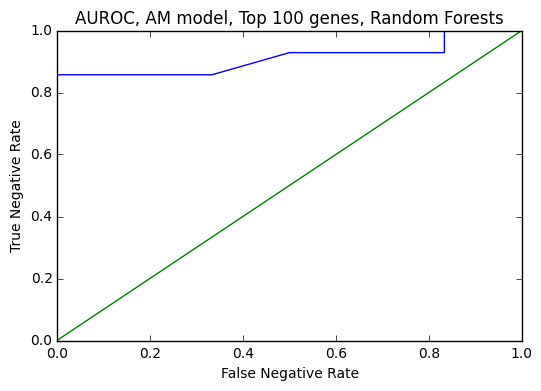

0.9166666666666667

In [41]:
plot_auroc(auroc_am_rf_100, 'AM model, Top 100 genes, Random Forests')
auc_calc(auroc_am_rf_100)

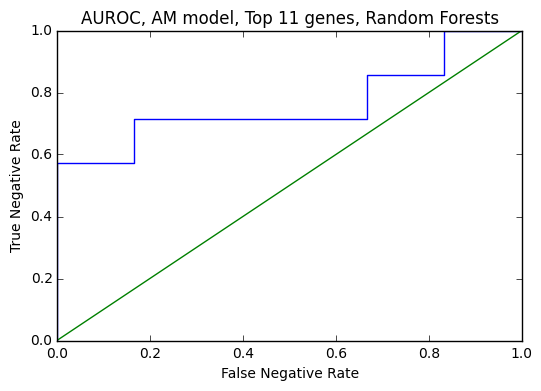

0.7619047619047619

In [42]:
plot_auroc(auroc_am_rf_11, 'AM model, Top 11 genes, Random Forests')
auc_calc(auroc_am_rf_11)

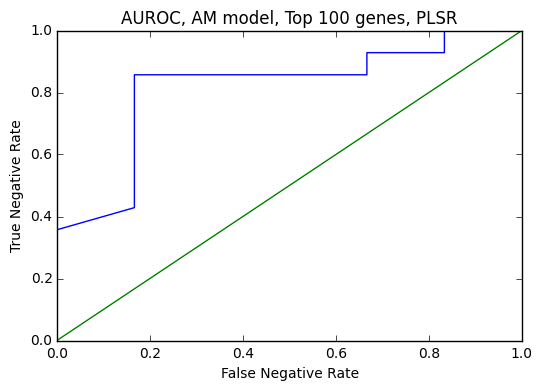

0.8214285714285714

In [43]:
plot_auroc(auroc_am_plsr_100, 'AM model, Top 100 genes, PLSR')
auc_calc(auroc_am_plsr_100)

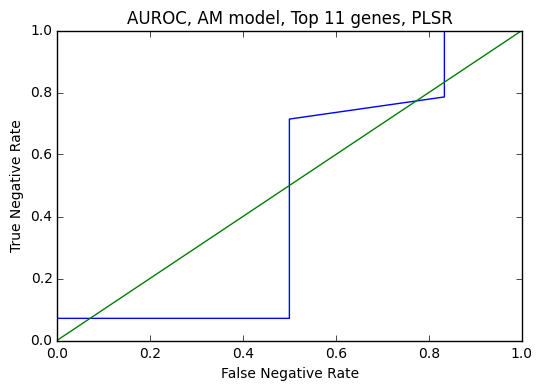

0.46428571428571425

In [44]:
plot_auroc(auroc_am_plsr_11, 'AM model, Top 11 genes, PLSR')

auc_calc(auroc_am_plsr_11)

### CD163

In [45]:
auroc_163_plsr_100 = run_model(celltype='CD163', response='original', n_top_genes=80, jumble_train=False,
                method='PLSR', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  CD163
Method =  PLSR
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


In [46]:
auroc_163_plsr_11 = run_model(celltype='CD163', response='original', n_top_genes=11, jumble_train=False,
                method='PLSR', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  CD163
Method =  PLSR
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


In [76]:
print_stats(aucs)

Mean: 0.69, Std: 0.05
95% CI (0.59014384312317036, 0.79652282354349635)


In [54]:
aucs = []
for i in tqdm(range(15)):
    auroc = run_model(celltype='CD163', response='original', n_top_genes=100, jumble_train=False, 
            method='RandomForests', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')
    auc = auc_calc(auroc)
    aucs.append(auc)
    

  0%|          | 0/15 [00:00<?, ?it/s]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


  7%|▋         | 1/15 [03:34<50:09, 214.96s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 13%|█▎        | 2/15 [07:09<46:34, 214.94s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 20%|██        | 3/15 [11:52<47:01, 235.17s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 27%|██▋       | 4/15 [23:04<1:07:07, 366.16s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 33%|███▎      | 5/15 [26:25<52:47, 316.72s/it]  

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 40%|████      | 6/15 [29:45<42:16, 281.83s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 47%|████▋     | 7/15 [33:05<34:18, 257.32s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 53%|█████▎    | 8/15 [38:49<33:02, 283.22s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 60%|██████    | 9/15 [42:09<25:49, 258.25s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 67%|██████▋   | 10/15 [45:28<20:01, 240.33s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 73%|███████▎  | 11/15 [48:48<15:13, 228.40s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 80%|████████  | 12/15 [1:22:31<38:20, 766.75s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 87%|████████▋ | 13/15 [1:26:54<20:31, 615.70s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 93%|█████████▎| 14/15 [1:30:14<08:10, 490.98s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


100%|██████████| 15/15 [1:33:34<00:00, 403.64s/it]


In [47]:
auroc_163_rf_100 = run_model(celltype='CD163', response='original', n_top_genes=100, jumble_train=False, 
                            method='RandomForests', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


In [80]:
print_stats(aucs_163_rf_11)

Mean: 0.64, Std: 0.04
95% CI (0.5618039468748387, 0.71248176741087577)


In [59]:
aucs_163_rf_11

[0.6857142857142857,
 0.6285714285714286,
 0.6285714285714286,
 0.5714285714285714,
 0.6571428571428571,
 0.6571428571428571,
 0.6857142857142857,
 0.6571428571428571,
 0.6285714285714286,
 0.5714285714285714]

In [58]:
aucs_163_rf_11 = []
for i in tqdm(range(10)):
    auroc = run_model(celltype='CD163', response='original', n_top_genes=11, jumble_train=False, 
            method='RandomForests', norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')
    auc = auc_calc(auroc)
    aucs_163_rf_11.append(auc)
    


  0%|          | 0/10 [00:00<?, ?it/s]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30



Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/tjyacoub/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tjyacoub/anaconda2/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 10%|█         | 1/10 [03:30<31:32, 210.31s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 20%|██        | 2/10 [06:51<27:40, 207.59s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 30%|███       | 3/10 [10:10<23:54, 204.94s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 40%|████      | 4/10 [1:02:39<1:48:49, 1088.17s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 50%|█████     | 5/10 [1:06:24<1:09:05, 829.20s/it] 

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 60%|██████    | 6/10 [1:10:27<43:33, 653.38s/it]  

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 70%|███████   | 7/10 [1:14:10<26:13, 524.43s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


 80%|████████  | 8/10 [1:17:44<14:22, 431.17s/it]


Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



 90%|█████████ | 9/10 [1:21:30<06:09, 369.52s/it]

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====



100%|██████████| 10/10 [1:25:01<00:00, 322.12s/it]


In [48]:
auroc_163_rf_11 = run_model(celltype='CD163', response='original', n_top_genes=11, jumble_train=False, method='RandomForests', 
                       norm='zscore', random_genes=False, jumble_test=False, sampling='', cross_validation='LOO')

Model =  CD163
Method =  RandomForests
Normalization =  zscore
Num pos after sampling: 15
Num neg after sampling: 30
Num pos after sampling: 7
Num neg after sampling: 5

===== Testing =====


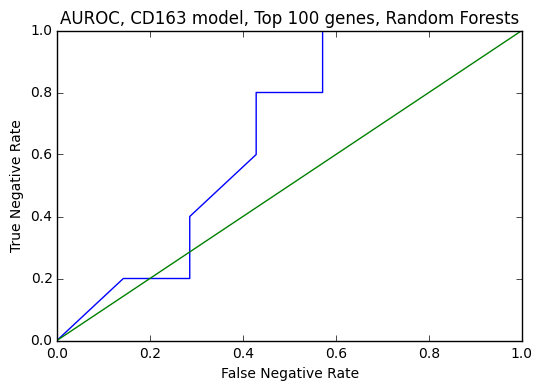

0.6857142857142857

In [49]:
plot_auroc(auroc_163_rf_100, 'CD163 model, Top 100 genes, Random Forests')
auc_calc(auroc_163_rf_100)

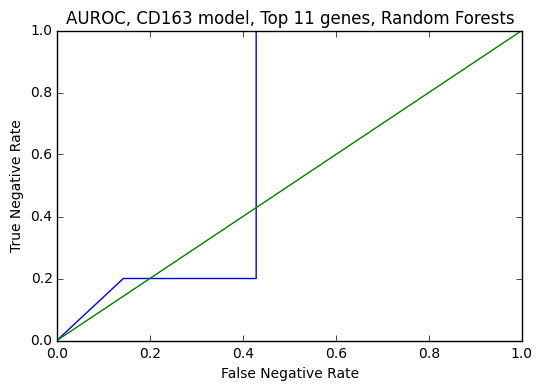

0.6571428571428571

In [50]:
plot_auroc(auroc_163_rf_11, 'CD163 model, Top 11 genes, Random Forests')
auc_calc(auroc_163_rf_11)

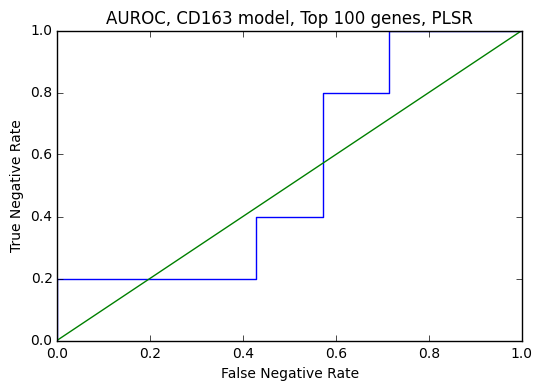

0.5428571428571429

In [51]:
plot_auroc(auroc_163_plsr_100, 'CD163 model, Top 100 genes, PLSR')
auc_calc(auroc_163_plsr_100)

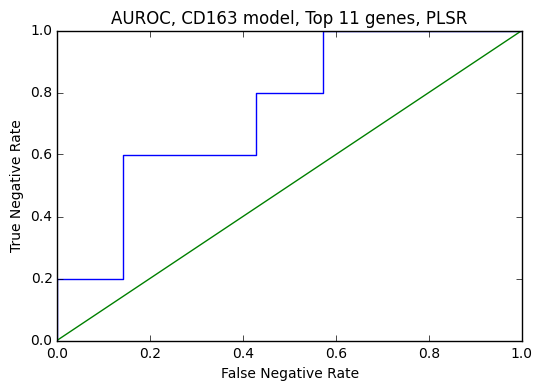

0.7428571428571429

In [53]:
plot_auroc(auroc_163_plsr_11, 'CD163 model, Top 11 genes, PLSR')
auc_calc(auroc_163_plsr_11)